# Imports

##### General imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import copy

##### Import from flatland environment 

In [3]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator,sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator, sparse_schedule_generator
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

##### Import from our framework

In [4]:
from src.graph import NetworkGraph
from src.flows import TimeNetwork
from src.flows import MCFlow

# Test of time expanded network

##### Create a flatland network

In [5]:
number_agents = 5

size_side = 100
stochastic_data = {'prop_malfunction': 0.3,  # Percentage of defective agents
                   'malfunction_rate': 30,  # Rate of malfunction occurence
                   'min_duration': 3,  # Minimal duration of malfunction
                   'max_duration': 20  # Max duration of malfunction
                   }
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train
env = RailEnv(width=size_side,
              height=size_side,
              rail_generator=sparse_rail_generator(max_num_cities=4,
                                                   # Number of cities in map (where train stations are)
                                                   seed=14,  # Random seed
                                                   grid_mode=False,
                                                   max_rails_between_cities=2,
                                                   max_rails_in_city=8,
                                                   ),
              schedule_generator=sparse_schedule_generator(speed_ration_map),
              number_of_agents=number_agents,
              stochastic_data=stochastic_data,  # Malfunction data generator
              obs_builder_object=GlobalObsForRailEnv(),
              remove_agents_at_target=True
              )

# RailEnv.DEPOT_POSITION = lambda agent, agent_handle : (agent_handle % env.height,0)
env.reset()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.AGENT_SHOWS_OPTIONS_AND_BOX,
                          show_debug=True,
                          screen_height=1100,
                          screen_width=1800)
env_renderer.reset()

env_renderer.render_env(show=True, show_observations=False, show_predictions=False)

matrix_rail = np.array(env.rail.grid.tolist())
flatlandNetwork = NetworkGraph(matrix_rail,[(0,1)],[(1,0)])

In [6]:
env.agents

[EnvAgent(initial_position=(10, 44), direction=3, target=(19, 87), moving=False, speed_data={'position_fraction': 0.0, 'speed': 0.5, 'transition_action_on_cellexit': 0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0}, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, handle=0, old_direction=None, old_position=None),
 EnvAgent(initial_position=(20, 87), direction=3, target=(11, 44), moving=False, speed_data={'position_fraction': 0.0, 'speed': 0.3333333333333333, 'transition_action_on_cellexit': 0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0}, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, handle=1, old_direction=None, old_position=None),
 EnvAgent(initial_position=(12, 44), direction=3, target=(78, 35), moving=False, speed_data={'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': 0}, malfunction_data={'malfunction': 0, 'malf

In [7]:
sources = []
sinks = []
for agent in env.agents:
    sources.append(agent.initial_position)
    sinks.append(agent.target)

##### create a time expanded network

In [8]:
import time

In [9]:
start = time.time()
TestNetworkTime = TimeNetwork(flatlandNetwork, depth=200)
stop = time.time()
print(f'time taken to build the graph: {stop-start}')

time taken to build the graph: 16.699960231781006


In [10]:
TestNetworkTime.connect_sources_and_sink(sources,sinks)

##### Test LP Formulation

test a simple graph

In [11]:
import datetime as dt
print(dt.datetime.now())

2019-11-10 19:14:47.505880


In [12]:
mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.get_topology_network(),integer = False)

Academic license - for non-commercial use only


In [13]:
mcflow.solve()

Optimize a model with 3312670 rows, 6084050 columns and 19744100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 0 rows and 0 columns (presolve time = 7s) ...
Presolve removed 2093564 rows and 4212322 columns (presolve time = 10s) ...
Presolve removed 3159671 rows and 5868851 columns (presolve time = 15s) ...
Presolve removed 3162585 rows and 5871765 columns (presolve time = 22s) ...
Presolve removed 3163329 rows and 5872609 columns
Presolve time: 33.16s
Presolved: 149341 rows, 211441 columns, 680199 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.984e+05
 Factor NZ  : 1.334e+07 (roughly 250 MBytes of memory)
 Factor Ops : 5.138e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal

In [14]:
paths = mcflow.get_paths_solution()

In [15]:
score = 0
for _,path in paths.items():
    score += int(len(path)/2)
    
print(f"score {score}")

score 162


In [16]:
lengths = []
pathsToAllongate = copy.deepcopy(mcflow.solution)
for agent,path in pathsToAllongate.items():
    lengths.append(len(path))
    
maxLength = max(lengths)
for agent,path in pathsToAllongate.items():
    for i in range(maxLength-len(path)):
        path.append(None)
    pathsToAllongate[agent] = path

In [17]:
dfPaths = pd.DataFrame(pathsToAllongate)
dfPaths

,0,1,2,3,4
0,"(10, 44)","(20, 87)","(12, 44)","(10, 43)","(19, 29)"
1,"(10, 45)","(20, 86)","(12, 43)","(10, 42)","(19, 30)"
2,"(10, 46)","(20, 85)","(12, 42)","(11, 42)","(19, 31)"
3,"(11, 46)","(19, 85)","(12, 41)","(11, 41)","(19, 32)"
4,"(11, 47)","(19, 84)","(12, 40)","(12, 41)","(19, 33)"
...,...,...,...,...,...
71,None,None,"(74, 35)","(73, 35)",None
72,None,None,"(75, 35)","(74, 35)",None
73,None,None,"(76, 35)","(75, 35)",None
74,None,None,"(77, 35)","(76, 35)",None


In [29]:
import datetime as dt
print(dt.datetime.now())

2019-11-10 19:29:19.750538


In [20]:
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 190),
          (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195),
          (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
colors = [(x[0]/255.,x[1]/255.,x[2]/255.) for x in colors]

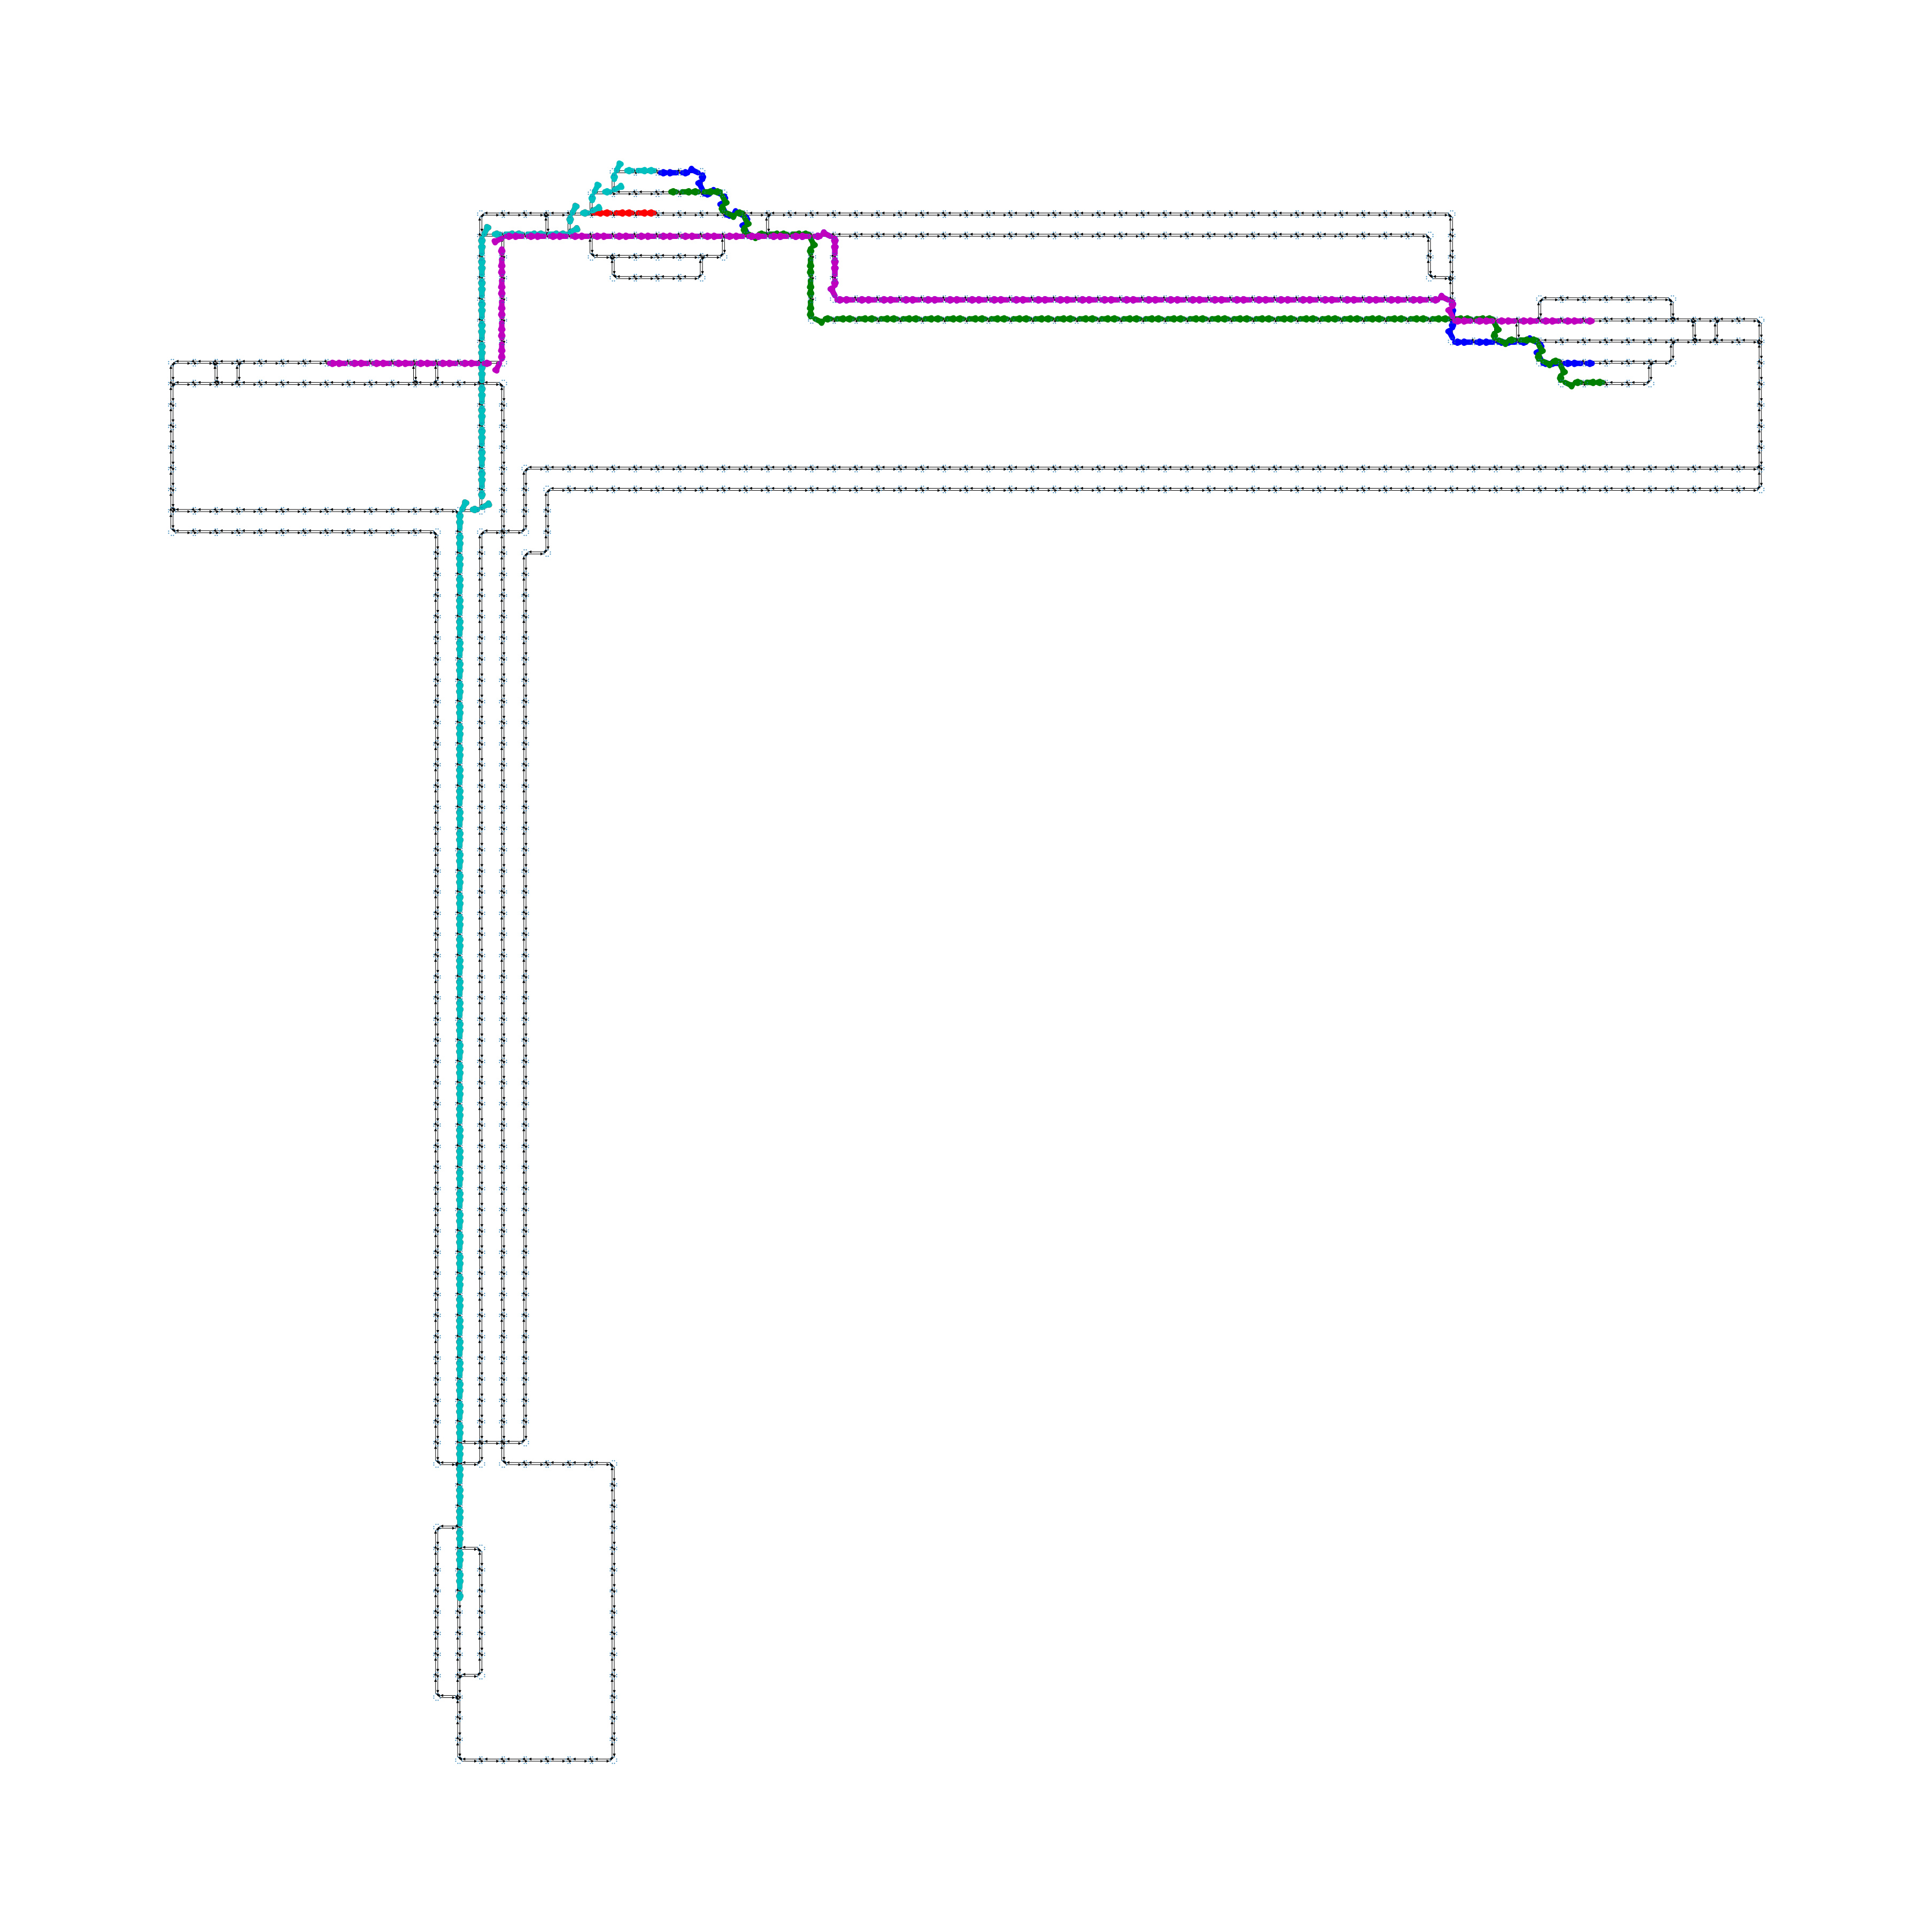

In [30]:
flatlandNetwork.show(paths = mcflow.solution_complete_edges)

In [ ]:
TestNetworkTime.show(paths = mcflow.solution_complete_edges)